# NBAS
NBAS variants are associated with 

[Infantile liver failure syndrome 2; OMIM:616483](https://omim.org/entry/616483) and
[Short stature, optic nerve atrophy, and Pelger-Huet anomaly; OMIM:614800](https://omim.org/entry/614800)

In [2]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using genophenocorr version 0.9.1


# NBAS
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NBAS.

In [3]:
gene_symbol = 'NBAS'
mane_tx_id = 'NM_015909.4'
mane_protein_id = "NP_056993.2"

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.23' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 67/67 [02:08<00:00,  1.92s/individuals]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
55,Acute hepatic failure
34,Short stature
28,Elevated circulating aspartate aminotransferase concentration
27,Elevated circulating alanine aminotransferase concentration
20,Hyposegmentation of neutrophil nuclei
18,Prolonged prothrombin time
16,Hyperammonemia
16,Decreased circulating IgG concentration
15,Hepatomegaly
15,Increased total bilirubin


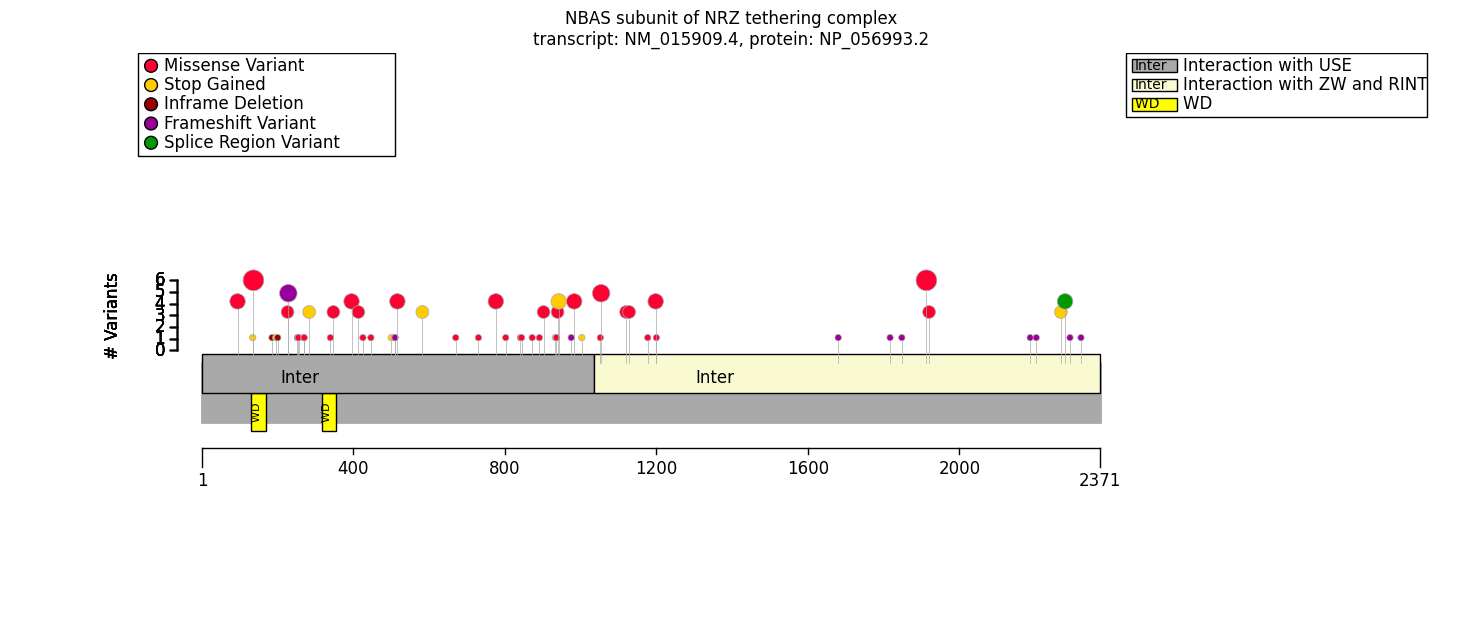

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
import matplotlib.pyplot as plt
from gpsea.view import ProteinVisualizer

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

nbas_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
nbas_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
68,Interaction with USE1,Region,2 - 1035,p.Ser414Phe; p.Cys256Tyr; p.Trp934Ter; p.Phe671Cys; p.Leu271Pro; p.Glu943Ter; p.Pro937Ala; p.Val253Gly; p.Trp396Arg; p.Glu447Lys; p.Ile984Ser; p.Arg1004Ter; p.Arg501Ter; p.Arg510Ter; p.Arg873Trp; p.Cys426Trp; p.His940Pro; p.Trp583Ter; p.Val892Phe; p.Lys284Ter; p.Ile512ThrfsTer4; p.Gln196Ter; p.Gly340Arg; p.Arg517Cys; p.Leu202del; p.Thr731Pro; p.His227Pro; p.Val842Phe; p.Ser976ProfsTer16; p.Ala95Val; p.Arg137Trp; p.Trp845Cys; p.Ile187del; p.Pro777His; p.Glu803Lys; p.Pro348Ser; p.Ser230GlnfsTer4; p.Gly254Asp; p.Gly270Ala; p.Ile984LeufsTer8; p.Arg517His; p.Trp396Ter; p.Trp135Ter; p.Leu903Arg
7,WD 1,Repeat,131 - 169,p.Arg137Trp; p.Trp135Ter
3,WD 2,Repeat,317 - 355,p.Gly340Arg; p.Pro348Ser
34,Interaction with ZW10 and RINT1,Region,1037 - 2371,p.Ser1819LysfsTer16; p.Gln2322HisfsTer18; p.Ser1681GlnfsTer37; p.His1053Arg; p.Arg1914Gly; p.Trp1850GlyfsTer32; p.Thr2280=; p.Ser1178Arg; p.Met2204IlefsTer3; p.Glu2189Ter; p.Ile1121Met; p.Ser1129Phe; p.Leu2293CysfsTer9; p.Arg1914His; p.Leu1055Pro; p.Glu2269Ter; p.Gln1201Pro; p.Cys1199Tyr; p.Ala1921Pro


In [8]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
6,2_15539327_15539327_G_A,c.409C>T (p.Arg137Trp),7,missense
6,SO:1000029_HGNC:15625_NBAS,SV involving NBAS (p.?),,chromosomal deletion
5,2_15238670_15238670_C_T,c.5741G>A (p.Arg1914His),45,missense
4,2_15394320_15394320_A_G,c.3164T>C (p.Leu1055Pro),28,missense
4,2_15534602_15534602_G_GA,c.686dup (p.Ser230GlnfsTer4),9,frameshift
3,2_15415656_15415656_C_A,c.2827G>T (p.Glu943Ter),25,stop gained
3,2_15374715_15374715_C_T,c.3596G>A (p.Cys1199Tyr),31,missense
3,2_15461210_15461210_G_T,c.2330C>A (p.Pro777His),21,missense
3,2_15554064_15554064_G_A,c.284C>T (p.Ala95Val),4,missense
2,2_15475787_15475787_G_A,c.1241C>T (p.Ser414Phe),14,missense


# Genotype Phenotype Correlation (GPC) Analysis

[Hammann et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/38244286/) suggested that missense or in-frame deletions in the C-terminal region of the NBAS gene are associated with  [SOPH syndrome (614800)](https://omim.org/entry/608025), missense or in-frame deletions in the Sec30 domain of NBAS are associated with [infantile liver failure syndrome type 2](https://omim.org/entry/616483), and missense or in-frame deletions in the beta-propeller domain of NBAS are associated with a combined phenotype of multisystem involvement with acute liver failure.

We will therefore test these proposed associations as well as a potential correlation of missese variants.

In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = biallelic_classifier(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                   partitions=((0,),(2,1))
                                   )
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,28
HMF03,Skipping term because of a child term with the same individual counts,2
HMF08,Skipping general term,91
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,231


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/missense          \
                                                               Count Percent   
Decreased circulating IgG concentration [HP:000...              1/12      8%   
Hyposegmentation of neutrophil nuclei [HP:0011447]              3/16     19%   
Acute hepatic failure [HP:0006554]                             19/20     95%   
Delayed skeletal maturation [HP:0002750]                        3/11     27%   
Motor delay [HP:0001270]                                        3/11     27%   
Reduced bone mineral density [HP:0004349]                       5/14     36%   
Short stature [HP:0004322]                                      8/14     57%   
Elevated circulating alanine aminotransferase c...               4/4    100%   
Elevated circulating hepatic transaminase conce...               9/9    100%   
Elevated circulating aspartate aminotransferase...               4/4    100%   
Hepatic failure [HP:0001399]                                   19/19    100%   
Growth delay [HP:0001510]                                        8/8    100%   

Allele group                                       other/other OR missense/other  \
                                                                           Count   
Decreased circulating IgG concentration [HP:000...                         15/23   
Hyposegmentation of neutrophil nuclei [HP:0011447]                         17/31   
Acute hepatic failure [HP:0006554]                                         36/43   
Delayed skeletal maturation [HP:0002750]                                    9/21   
Motor delay [HP:0001270]                                                    8/20   
Reduced bone mineral density [HP:0004349]                                   9/20   
Short stature [HP:0004322]                                                 26/40   
Elevated circulating alanine aminotransferase c...                         23/24   
Elevated circulating hepatic transaminase conce...                         25/25   
Elevated circulating aspartate aminotransferase...                         24/25   
Hepatic failure [HP:0001399]                                               36/36   
Growth delay [HP:0001510]                                                  26/26   

Allele group                                                                   \
                                                   Percent Corrected p values   
Decreased circulating IgG concentration [HP:000...     65%           0.019335   
Hyposegmentation of neutrophil nuclei [HP:0011447]     55%           0.171827   
Acute hepatic failure [HP:0006554]                     84%           1.000000   
Delayed skeletal maturation [HP:0002750]               43%           1.000000   
Motor delay [HP:0001270]                               40%           1.000000   
Reduced bone mineral density [HP:0004349]              45%           1.000000   
Short stature [HP:0004322]                             65%           1.000000   
Elevated circulating alanine aminotransferase c...     96%           1.000000   
Elevated circulating hepatic transaminase conce...    100%           1.000000   
Elevated circulating aspartate aminotransferase...     96%           1.000000   
Hepatic failure [HP:0001399]                          100%           1.000000   
Growth delay [HP:0001510]                             100%           1.000000   

Allele group                                                  
                                                    p values  
Decreased circulating IgG concentration [HP:000...  0.001611  
Hyposegmentation of neutrophil nuclei [HP:0011447]  0.028638  
Acute hepatic failure [HP:0006554]                  0.417571  
Delayed skeletal maturation [HP:0002750]            0.464673  
Motor delay [HP:0001270]                            0.697875  
Reduced bone mineral density [HP:0004349]           0.728237  
Short stature [HP:0004322]                          0.749427  


In [15]:
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal import SurvivalAnalysis

term_id = "OMIM:614800"  # Short stature, optic nerve atrophy, and Pelger-Huet anomalz
endpoint = disease_onset(disease_id=term_id)
survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=endpoint,
)
print(result.pval)

0.3862204659641929


0.12464937285319633


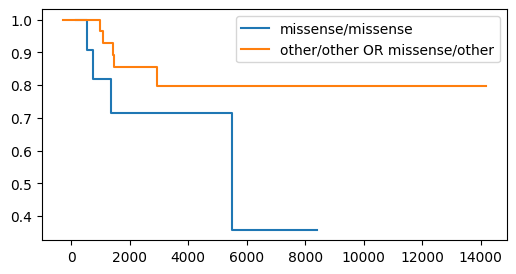

In [17]:
from gpsea.analysis.temporal.endpoint import death
term_id = "OMIM:614800"  # Short stature, optic nerve atrophy, and Pelger-Huet anomalz
survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=death(),
)
print(result.pval)

_, ax = plt.subplots(figsize=(6, 3))
result.plot_kaplan_meier_curves(ax)

# Missense or frameshift variants in the https://omim.org/entry/616483

In [19]:
from gpsea.analysis.predicate import anyof, variant_key

r1914h = variant_key("2_15238670_15238670_C_T") # c.5741G>A	p.Arg1914His
a1921p = variant_key("2_15238650_15238650_C_G") # c.5761G>C	p.Ala1921Pro
sv = variant_key("SO:1000029_HGNC:15625_NBAS") # by inspection, these are all C term

c_term_missense = anyof((r1914h, a1921p, sv))

c_term_clf =  biallelic_classifier(a_predicate=c_term_missense, 
                                   b_predicate=~c_term_missense, 
                                   a_label="missense",
                                   b_label="other",
                                   partitions=((0,),(2,1))
                                   )


c_term_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=c_term_clf,
    pheno_clfs=pheno_clfs,
)
viewer.process(c_term_result)
#summarize_hpo_analysis(hpo=hpo, result=c_term_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,39
HMF05,Skipping term because one genotype had zero observations,12
HMF08,Skipping general term,91
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,222
